# Translation with RNN Autoencoder

In this project we will be teaching a neural network to translate from French to English. This is made possible by the simple but powerful idea of the "Seq2Seq" network, in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence. To improve upon this model we’ll use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence.

### Import libraries

In [1]:
# import standard libraries
from __future__ import unicode_literals, print_function, division
from IPython.display import Image
from io import open
import unicodedata
import string
import re
import random
import time
import math
import numpy as np
import numpy.random as npr
import operator
import os

# torch
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from translation import *

# Loading data files

The data for this project is a set of many thousands of English to French translation pairs:  **The pen is on the table**  ---  **Le stylo est sur la table**. We will be representing each word in a language as a one-hot vector. However we do not consider the whole dictionary of both languages, limiting ourselves to use just a few thousand words per language.

We first define a class called **Lang**  to produce **word2index**,  **index2word** and **word2count**  dictionaries.

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English we added the reverse flag to reverse the pairs.

Given time constraints that we have,  we are drastically simplifying the task, limiting the data-set to only relatively short and simple sentences. Here the **maximum length** is 10 words and we’re **filtering to sentences** whose translation contain the simple sentences of type “I am” or “He is” etc.

### text cleaning functions

In [4]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

### reading functions

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

### filtering functions

In [6]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### data processing

The full process for preparing the data is:

1.   Read text file and split into lines, split lines into pairs
2.   Normalize text, filter by length and content
3.   Make word lists from sentences in pairs

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=True)
print('example: ', random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
example:  ['je suis en train d apprendre le francais .', 'i m learning french .']


In [8]:
# Considered # of words
# output_lang.word2count

# The RNN Autoencoder Model (Seq2Seq)

## Preliminary: Recurrent Neural Network

A recurrent neural network (RNN) is a neural network that consists of a hidden state $h$ and an output $y$ which operates in a variable length input sequence $x=(x_1,...x_T)$. At each time step $t$, the hiddent state $h_t$ is updated via the following equation:

$$h_t = f(h_{t-1}, x_t)$$

where $f$ is a non-linear activation function. Classically, the main objective of a RNN is to learn a probability distribution over a sequence  by being trained to predict the next symbol in a sequence. In that case, the output at each timestep t$$ is the conditional distribution

$$p(x_t| x_{t−1}, . . . , x_1)$$

The **main limitation of RNNs for natural language processing** is well illustrated in the following example:

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

## RNN Autoencoder

In " *Learning Phrase Representations using RNN Encoder–Decoder
for Statistical Machine Translation*" the authors propose a neural network architecture that learns to encode a variable-length
sequence into a fixed-length vector representation and to decode a given fixed-length vector representation back into a variable-length sequence.
From a probabilistic perspective, their model
tries to learn the **conditional distribution over a variable-length sequence conditioned on yet another variable-length sequence**

$$p(y_1,...,y_{T'} | x_1,...,x_T)$$

where $T \neq T'$. The encoder is an RNN that reads each symbol
of an input sequence $x$ sequentially. As it reads each symbol, the hidden state $h$ of the RNN changes according to teh equation above. After reading the end of the sequence (marked by an end-of-sequence token "EOS"),  ** the hidden state of the RNN is a summary c
of the whole input sequence. c is a very important object, as it encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences**.

Now the decoder comes into play. The decoder is another RNN which is trained to generate the output sequence by predicting the next symbol $y_t$ given the hidden state $h_t$. However this time both $y_t$ and $h_t$ are conditioned on $y_{t-1}$ and the summary ** c ** produced by the encoder from the input sequence. Therefore the hidden state $h_t$ of the decoder at time $t$ is computed as follows:

$$h_t = f(h_{t-1}, y_{t-1}, c)$$

Similarly the conditional distribution of the next symbol in the output sequence is:

$$p(y_t|y_{t-1}, ..., y_1, c) = g(h_t, y_{t-1}, c)$$

where g and f are valid activation function (and g is constrained to output a probability, e.g. *softmax*)

The two components of the RNN Autoencoder model are jointly trained to maximize the conditional (log-)likelihood:

$$\max_{\theta}\frac{1}{N}\sum_{n=1}^Nlog \ p_{\theta}(y_n|x_n)$$

where $\theta$ is the set of model parameters and each $(x_n, y_n)$ represents a pair of input/ouput sequences.


# Our Experiments

## Word Embeddings in Pytorch

In Pytorch embeddings are stored as a $|V|$ x $D$ matrix where $D$ is the dimension of the embedding space and $|V|$ is the size of the dictionary. Therefore the word assigned to index $i$ has its embedding stored in the $i^{th}$ row of the matrix. Our mapping dictionary "word2index" does exactly this. The Pytorch module that allows to use embeddings in Pytorch is ***torch.nn.Embedding*** , which takes two arguments: the vocabulary size, and the dimensionality of the embeddings.

In [9]:
# One-Hot-Encoding representation
# output_lang.word2index

In [10]:
# embedding example
dic_size = len(output_lang.word2index)
embedding_size = 5
embeds = nn.Embedding(dic_size, embedding_size)
for k in [32, 43, 555]:
  w = list(output_lang.word2count.keys())[k]
  emb = embeds(torch.tensor([output_lang.word2index[w]], dtype=torch.long))
  print('the embedding of the word "{}" is {}'.format(w, emb.tolist()))

the embedding of the word "tall" is [[-0.08346078544855118, -0.5427628755569458, 0.8992401361465454, -1.0783393383026123, -1.085896611213684]]
the embedding of the word "rich" is [[-0.4686416685581207, 0.7084706425666809, -0.3934786915779114, 1.0893388986587524, -0.49916860461235046]]
the embedding of the word "standing" is [[-0.5941857695579529, 1.776494026184082, -0.899247944355011, -0.9078899025917053, 0.6937679052352905]]


In the following model word embeddings are learnt within the network!

## The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

We make use of a multi-layer gated recurrent unit (**GRU**) RNN. For each element in the input sequence, each layer computes the following functions:

$$r_t = \sigma(W_i^rx_t + b_{ir} + W_h^rh_{t-1} + b_h^r)$$

$$z_t = \sigma(W_i^zx_t + b_i^z + W_h^zh_{t-1} + b_h^z)$$

$$n_t = tanh(W_i^nx_t+b_i^n + r_t(W_h^nh_{t-1} + b_h^n))$$

$$h_t = (1-z_t)n_t+z_th_{t-1}$$

where $h_t$  is the hidden state at time t, $x_t$ is the input at time t, $h_{t-1}$ is the hidden state of the layer at time t-1, and $r_t, z_t, n_t$ are the reset, update, and new gates, respectively. $\sigma$ is the sigmoid activation function. Furtrhemore, in a multilayer GRU, the input $i_t^l$ of the $l^{th}$ layer is the hidden state $h_t^{l-1}$ of the preevious layer multiplied by dropout $\delta_t^{l-1}$ (usually taken to be a Bernoulli random variable)

## The Decoder

The decoder is another RNN that takes the encoder output vector(s) from the first RNN and outputs a sequence of words representing the translation. In the simplest seq2seq decoder we use **only the last output of the encoder**. This last output is sometimes called the **context vector** as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder. At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string token, and the first hidden state is the context vector (the encoder’s last hidden state).

## Preparing Training Data

To train, for each pair of sentences we will need an input tensor (represented by indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.


## Training the Model

To train the model we push the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the SOS token as its first input, and the last hidden state of the encoder as its first hidden state.

The whole training process looks like this:

1.   Start a timer
2.   Initialize optimizers and criterion
3.   Create set of training pairs
4.   Start empty losses array for plotting
5.   Call train many times and occasionally print the progress and average loss.

## Model Evaluation

Evaluation is mostly the same as training, but there are** no targets** so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

Presumably the use wishs to evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements. We wrote a function to do just that.



## Let's start the dance!

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer

In [11]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, n_iters=100000, pairs=pairs, input_lang=input_lang, 
           output_lang=output_lang, print_every=10000, with_attention=False)

KeyboardInterrupt: 

In [0]:
# evaluate
evaluateRandomly(encoder1, decoder1, input_lang, output_lang, pairs, n=3, with_attention=False)

> tu n es plus mon ami .
= you re not my friend anymore .
< you re not my friend anymore . <EOS>

> je suis aussi affame qu un ours .
= i m as hungry as a bear .
< i m as hungry as a bear . <EOS>

> elle est dotee d un talent special .
= she is endowed with a special talent .
< she is endowed a special special . . <EOS>



## Visualizing Embeddings

In [0]:
embeds = encoder1.embedding
embed_dic = {}
for w, h in input_lang.word2index.items():
  embed_dic[w] = embeds(torch.tensor([h], dtype=torch.long, device='cuda')).cpu().detach().numpy()

## t-SNE projection

In [0]:
from sklearn.manifold import TSNE
X = [x.reshape(-1,) for x in embed_dic.values()]

X_embedded = TSNE(n_components=2, 
#                   perplexity=150, 
#                   early_exaggeration=50.,
#                   learning_rate = 30.,
#                   n_iter=2000,
                  verbose=1).fit_transform(np.array(X))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4343 samples in 0.052s...
[t-SNE] Computed neighbors for 4343 samples in 10.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4343
[t-SNE] Computed conditional probabilities for sample 2000 / 4343
[t-SNE] Computed conditional probabilities for sample 3000 / 4343
[t-SNE] Computed conditional probabilities for sample 4000 / 4343
[t-SNE] Computed conditional probabilities for sample 4343 / 4343
[t-SNE] Mean sigma: 2.958045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.672417
[t-SNE] KL divergence after 1000 iterations: 4.097610


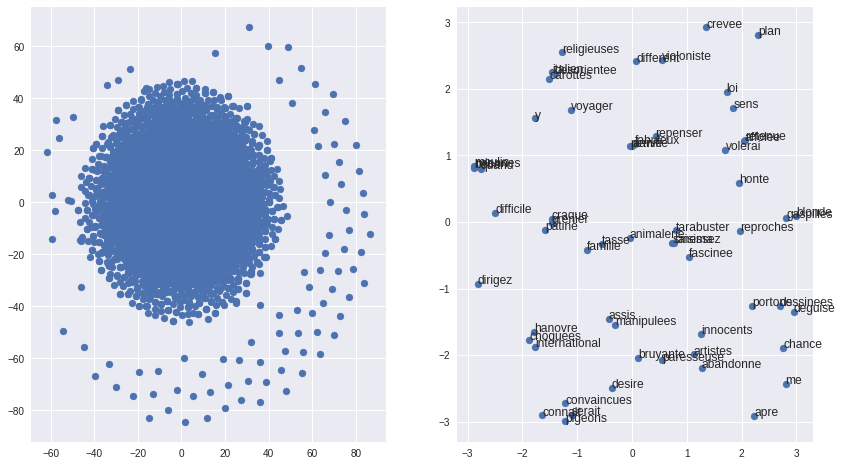

In [0]:
fix, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].scatter(X_embedded[:,0], X_embedded[:,1])
restriction = 3
zoom = [(x,tx) for x,tx in zip(X_embedded,embed_dic.keys()) if (np.abs(x[0])<restriction)&(np.abs(x[1])<restriction)]
X_embedded_zoom = np.array([k[0] for k in zoom]).reshape(-1,2)
ax[1].scatter(X_embedded_zoom[:,0], X_embedded_zoom[:,1])
for i, txt in zoom:
    ax[1].annotate(txt, (i[0], i[1]))
plt.show()

## Sentences Representations

In [0]:
sentences = [s[0] for s in pairs]
sentences_representations = []
for pair in pairs:
    _, learned_sentence_representation = evaluate(encoder1, decoder1, pair[0], 
                                                     input_lang, output_lang, with_attention=False)
    sentences_representations.append(learned_sentence_representation.cpu().detach().numpy().reshape(-1,))

## t_SNE, again

In [0]:
S_embedded = TSNE(n_components=2, 
#                   perplexity=150, 
#                   early_exaggeration=50.,
#                   learning_rate = 30.,
#                   n_iter=2000,
                  verbose=1).fit_transform(np.array(sentences_representations))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10599 samples in 0.183s...
[t-SNE] Computed neighbors for 10599 samples in 61.600s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10599
[t-SNE] Computed conditional probabilities for sample 2000 / 10599
[t-SNE] Computed conditional probabilities for sample 3000 / 10599
[t-SNE] Computed conditional probabilities for sample 4000 / 10599
[t-SNE] Computed conditional probabilities for sample 5000 / 10599
[t-SNE] Computed conditional probabilities for sample 6000 / 10599
[t-SNE] Computed conditional probabilities for sample 7000 / 10599
[t-SNE] Computed conditional probabilities for sample 8000 / 10599
[t-SNE] Computed conditional probabilities for sample 9000 / 10599
[t-SNE] Computed conditional probabilities for sample 10000 / 10599
[t-SNE] Computed conditional probabilities for sample 10599 / 10599
[t-SNE] Mean sigma: 3.641896
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.208000
[t-SNE] KL

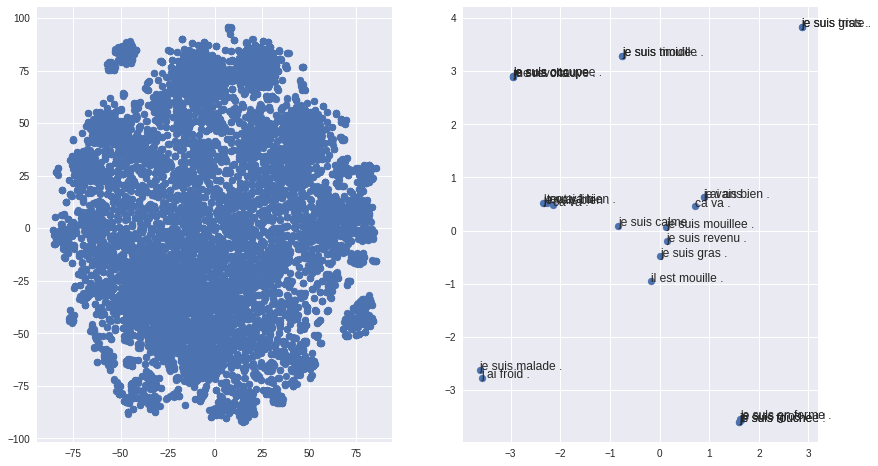

In [0]:
fix, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].scatter(S_embedded[:,0], S_embedded[:,1])
restriction = 4
zoom = [(x,tx) for x,tx in zip(S_embedded,sentences) if (np.abs(x[0])<restriction)&(np.abs(x[1])<restriction)]
S_embedded_zoom = np.array([k[0] for k in zoom]).reshape(-1,2)
ax[1].scatter(S_embedded_zoom[:,0], S_embedded_zoom[:,1])
for i, txt in zip(S_embedded_zoom, sentences):
    ax[1].annotate(txt, (i[0], i[1]))
plt.show()

# Attention Decoder

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.** Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs**. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

**Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs**. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

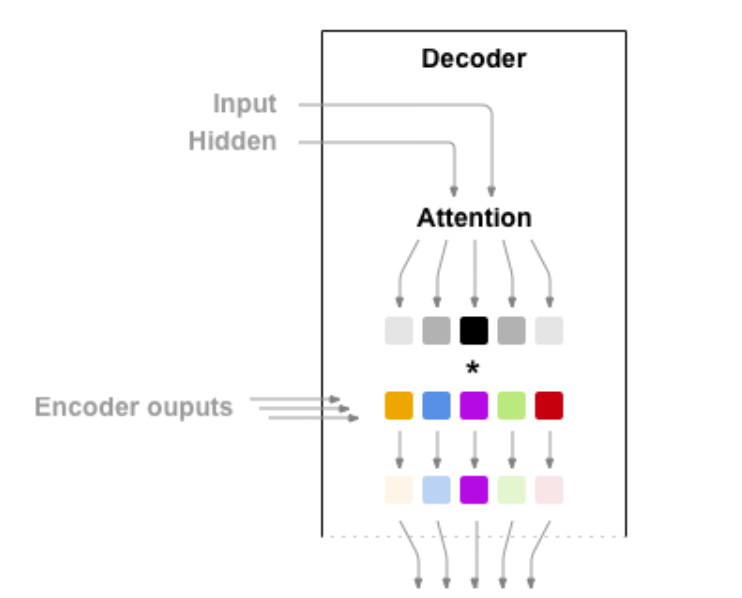

In [0]:
Image('attention.PNG', width=350, height=350)

**“Teacher forcing”** is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to **converge faster** but when the trained network is exploited, it may exhibit **instability**.

We can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively the network has learned to represent the output grammar and can pick up the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn "teacher_forcing_ratio" up to use more of it.

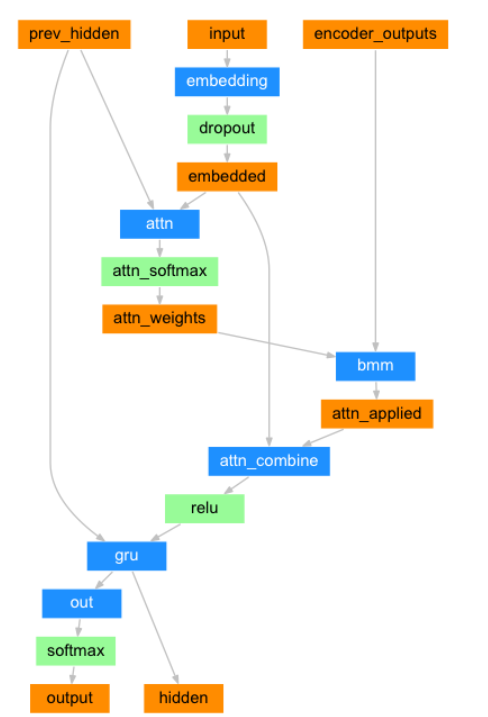

In [0]:
Image('attention_decoder.PNG', width=350, height=450)

In [0]:
# show class attention decoder

4m 37s (- 30m 5s) (10000 13%) 2.5607
9m 5s (- 25m 0s) (20000 26%) 1.8693
13m 36s (- 20m 25s) (30000 40%) 1.4547
18m 11s (- 15m 55s) (40000 53%) 1.1522
22m 40s (- 11m 20s) (50000 66%) 0.9605
27m 6s (- 6m 46s) (60000 80%) 0.8068
31m 40s (- 2m 15s) (70000 93%) 0.6761


<Figure size 576x396 with 0 Axes>

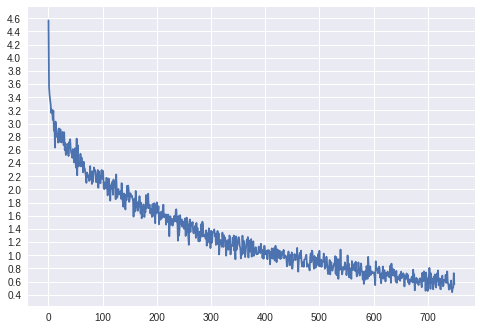

In [0]:
# train_with_attention  

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, n_iters=75000, pairs=pairs, input_lang=input_lang, 
           output_lang=output_lang, print_every=10000, with_attention=True)

In [0]:
evaluateRandomly(encoder1, attn_decoder1, input_lang, output_lang, pairs, n=3, with_attention=True)
 

> vous etes fort raffines .
= you re very sophisticated .
< you re very sophisticated . <EOS>

> il ne se trouve pas en ville .
= he s out of town .
< he s out of town . <EOS>

> il est dj .
= he is a dj .
< he is a . <EOS>



## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

In [0]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions,_ = evaluate(encoder1, attn_decoder1, input_sentence, 
                                        input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she s six years younger than me . <EOS>


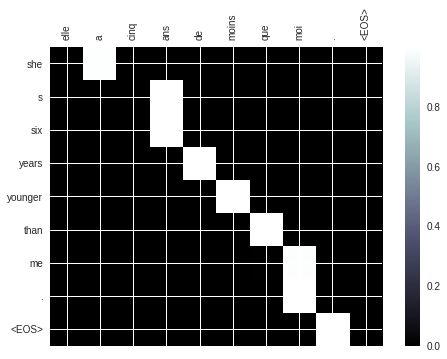

input = je ne crains pas de mourir .
output = i m not afraid of dying . <EOS>


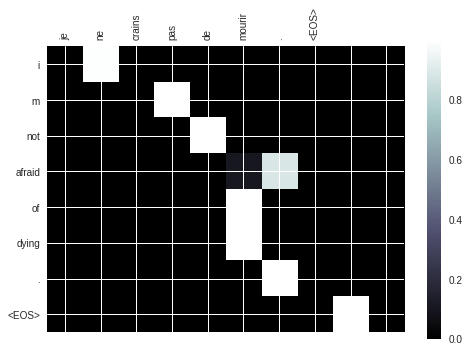

In [0]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

# evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# Latent ODE model

Today, multiple neural network architectures such as RNNs or Residual Networks contain repeating blocks of layers that have the ability to retain sequential information as well as change it in every step through a learned function. Such networks may in general be described by the equation:

$$h_{t+1} = h_t + f(h_t, \theta_t)$$

where $h_t$ is the “hidden” information at timestep t, and f(hₜ, θₜ) is the learned function of the current hidden information and parameters θₜ. What happens if we add more layers and take a smaller time step?

$$\frac{dh(t)}{dt} = f(h(t), t, \theta)$$

This equation defines an initial value problem. Starting with the input layer $h(0)$ we can solve the above ODE and  compute $h(T)$.  This value can be computed by a differential equation solver, which evaluates the hidden unit dynamics f wherever necessary to determine the solution.

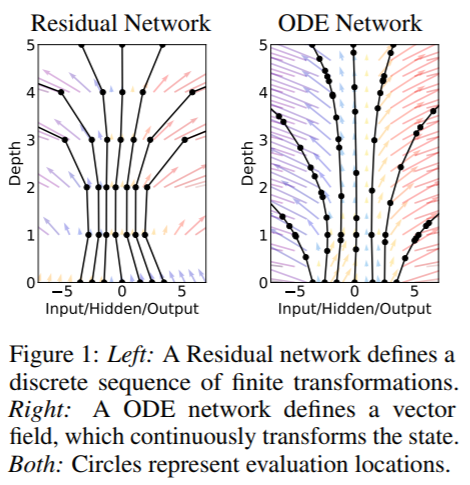

In [0]:
Image('ode_net.PNG', height=450, width=450)

### Advantages (according to the authors):



1.  ** Memory efficiency**: they show how to compute gradients of a scalar-valued loss with
respect to all inputs of any ODE solver, without backpropagating through the operations of the solver. Not storing any intermediate quantities of the forward pass allows us to train our models with constant memory cost as a function of depth.

2.   **Adaptivness**: ODE solvers monitor the level of error and adapt their evaluation strategy on th fly (variable step size) to achieve the required level of accuracy. 

3.   **Continuous time-series models**: Unlike RNNs, which require discretizing observations and emissions intervals, continuous dynamics can process any time parametrization in the same way.


## But how do we train such a model?

The main technical difficulty in training continuous-depth networks is performing backpropagation through the ODE solver. The authors treat the ODE solver as a "black-box", and compute gradients using the **adjoint method**. This methods consists in computing gradients by solving a second ODE backwards in time. 

From the equation above we know that

$$h_{t_1} = h_{t_0} + \int_{t_0}^{t_1}f(h(t),t,\theta)dt$$


Using any ODE solver we have:

$$h_{t_1} = ODESolve(h_{t_0}, f, t_0, t_1, \theta)$$.

Consider a loss function $L$. Then:

$$L(h_{t_1}) = L(ODESolve(h_{t_0}, f, t_0, t_1, \theta))$$

To optimize $L$ we require gradients with respect to $\theta$. For this we first need to compute $\frac{dL}{dh(t)}:=a(t)$, called the *adjoint*. It can be proved that its dynamics are given by another ODE:

$$\frac{da(t)}{dt} = -a(t)^T\frac{df(h(t), t, \theta)}{dh}$$.

The first value $a(0) = \frac{dL}{dh(0)}$ can be computed by another call to the ODE solver, that this time must be run backwards, starting from $\frac{dL}{dh(1)}$. 

Finally we can compute:

$$\frac{dL}{d\theta} = \int_{t_1}^{t_0}a(t)^T\frac{df(h(t), t, \theta)}{d\theta}dt$$.

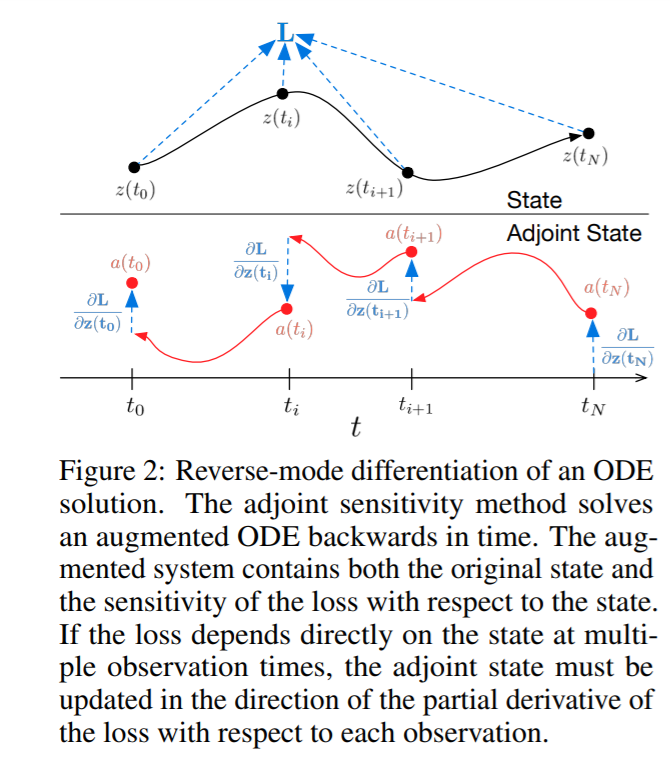

In [0]:
Image('dynamics.PNG', width=450, height=400)

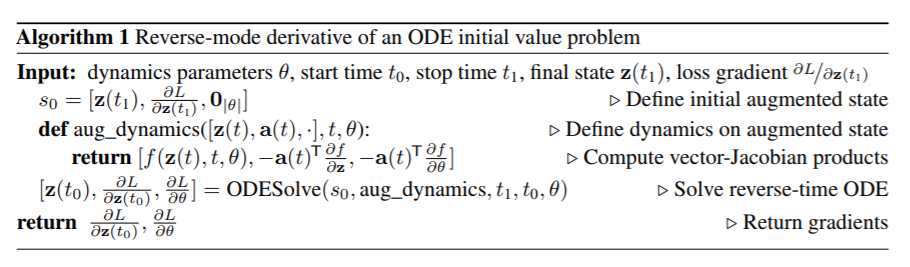

In [0]:
Image('reverse_mode_diff.PNG', width=700)

## Application to time-series data.

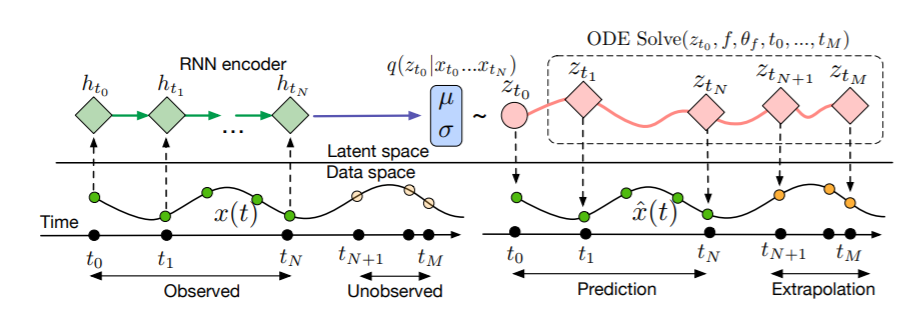

In [0]:
Image('ode_model.PNG', width=900, height=300)

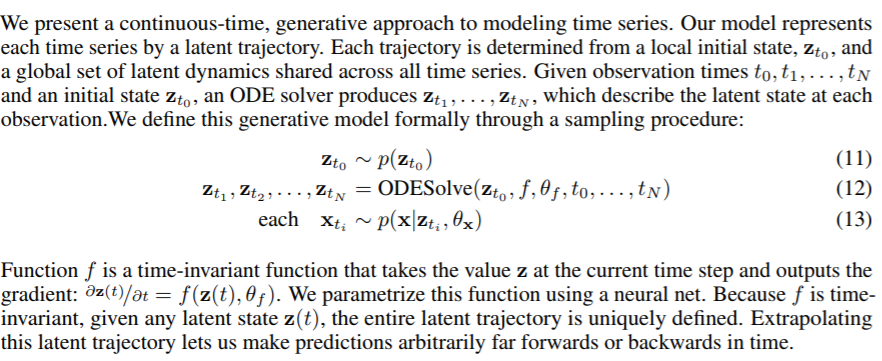

In [0]:
Image('explanation.PNG', height=300, width=800)

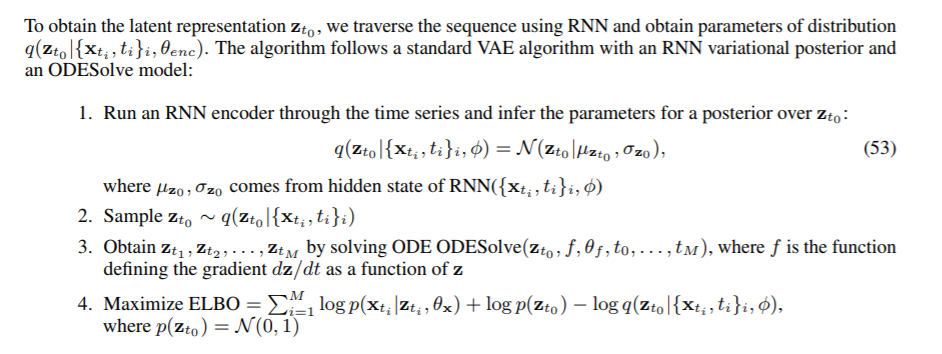

In [0]:
Image('ode_algo.PNG', height=300, width=800)

## Example on spirals

### import libraries

In [0]:
!git clone https://github.com/rtqichen/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 683.91 KiB | 5.38 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [0]:
%cd torchdiffeq/

/content/NLP/torchdiffeq


In [0]:
!ls

assets	examples  LICENSE  README.md  setup.py	tests  torchdiffeq


In [0]:
!pip install -e .

Obtaining file:///content/NLP/torchdiffeq
  Running setup.py develop for torchdiffeq


In [0]:
from torchdiffeq import odeint

In [0]:
%cd /content/NLP/

/content/NLP


In [0]:
from ODE_method import *

### Latent ODE model

In [0]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

### generate spirals

In [0]:
# variables for spirals
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100
learning_rate = 0.01


# generate toy spiral data
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(nspiral=nspiral,
                                                             start=start,
                                                             stop=stop,
                                                             noise_std=noise_std,
                                                             a=a, b=b)
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

### model preliminaries

In [0]:
# model
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=learning_rate)
loss_meter = RunningAverageMeter()

In [0]:
adjoint=False
niters=2000
train_dir=None
print_every_iter = 500

if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

### training the model

In [0]:
# store results of the model
if train_dir is not None:
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    ckpt_path = os.path.join(train_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        func.load_state_dict(checkpoint['func_state_dict'])
        rec.load_state_dict(checkpoint['rec_state_dict'])
        dec.load_state_dict(checkpoint['dec_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        orig_trajs = checkpoint['orig_trajs']
        samp_trajs = checkpoint['samp_trajs']
        orig_ts = checkpoint['orig_ts']
        samp_ts = checkpoint['samp_ts']
        print('Loaded ckpt from {}'.format(ckpt_path))

# start training from scratch
try:
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(1))):
            obs = samp_trajs[:, t, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
        pred_x = dec(pred_z)

        # compute loss
        noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
        noise_logvar = 2. * torch.log(noise_std_).to(device)
        logpx = log_normal_pdf(samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
        analytic_kl = normal_kl(qz0_mean, qz0_logvar, pz0_mean, pz0_logvar).sum(-1)
        loss = torch.mean(-logpx + analytic_kl, dim=0)
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        
        if itr % print_every_iter == 0:
          print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

# restart training from where we left it
except KeyboardInterrupt:
    if train_dir is not None:
        ckpt_path = os.path.join(train_dir, 'ckpt.pth')
        torch.save({
            'func_state_dict': func.state_dict(),
            'rec_state_dict': rec.state_dict(),
            'dec_state_dict': dec.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'orig_trajs': orig_trajs,
            'samp_trajs': samp_trajs,
            'orig_ts': orig_ts,
            'samp_ts': samp_ts,
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
print('Training complete after {} iters.'.format(itr))

Iter: 500, running avg elbo: -620.5641
Iter: 1000, running avg elbo: -150.1986
Iter: 1500, running avg elbo: -124.9568
Iter: 2000, running avg elbo: -353.7214
Training complete after 2000 iters.


## Visualize learning results

Saved visualization figure at ./vis.png


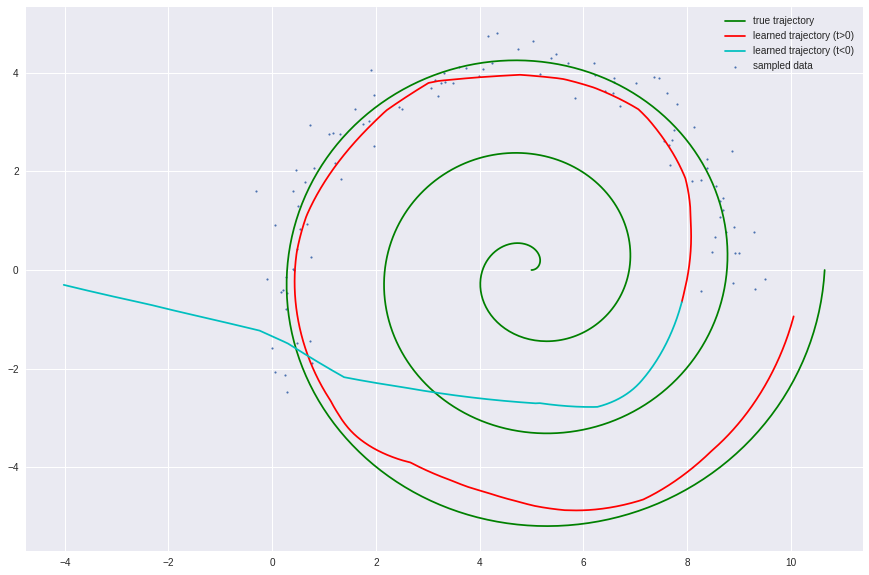

In [0]:
with torch.no_grad():
    # sample from trajectorys' approx. posterior
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    orig_ts = torch.from_numpy(orig_ts).float().to(device)

    # take first trajectory for visualization
    z0 = z0[0]

    ts_pos = np.linspace(0., 2. * np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)

    zs_pos = odeint(func, z0, ts_pos)
    zs_neg = odeint(func, z0, ts_neg)

    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = orig_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure(figsize=(15, 10))
plt.plot(orig_traj[:, 0], orig_traj[:, 1],
         'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
         label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
         label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[
            :, 1], label='sampled data', s=3)
plt.legend()
plt.savefig('./vis.png', dpi=500)
print('Saved visualization figure at {}'.format('./vis.png'))


## !!!! The idea is to replace the above decoder with the ODESolver!!!!

# Signature Translation

Here we experiment the idea consisting in using a pretrained word represenation (here we chose Glove) and interpret sentences as streams of embedded words. We used the smallest Glove representantion available online (Wikipedia 2014) which contains the embedding in R^50 of ~ 400K words. Therefore we consider sentences as 5--dimensional paths. **The idea is to replace the encoder of the RNN Autoencoder model by a fixed sentence representation given by the signature at level 2 or 3 of the embedded sentence. This representation is non-trainable (for now as we don't have sig backprop) and is feeded directly to the decoder. **

## Glove

### import libraries

In [0]:
!pip install -U bcolz

    100% |████████████████████████████████| 1.5MB 14.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [0]:
import bcolz
import pickle

In [0]:
%cd /content

/content


### read Glove embedding

In [0]:
# read glove file
words = []
idx = 0
word2idx = {}
glove_path = 'glove'
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}.6B.50.dat', mode='w')

with open(f'{glove_path}.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400001, 50)), rootdir=f'{glove_path}.6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}.6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}.6B.50_idx.pkl', 'wb'))

# create dictionary
vectors = bcolz.open(f'{glove_path}.6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}.6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}.6B.50_idx.pkl', 'rb'))
glove = {w: vectors[word2idx[w]] for w in words}

### embedding example

In [0]:
# embedding example
glove['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

Here we try to translate English ----> French, so the previous output_lang becomes the input_lang and vice-versa

### define embedding matrix for autoencoder

In [0]:
%cd /content/NLP

/content/NLP


In [0]:
output_lang, input_lang, pairs_new = prepareData('eng', 'fra', reverse=True)
pairs = [[p[1], p[0]] for p in pairs_new]

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [0]:
matrix_len = input_lang.n_words
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0
emb_dim = 50
for i, word in enumerate(input_lang.word2count.keys()):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

### findings

In [0]:
print('we found {} words embedding in Glove, out of {} words'.format(words_found, matrix_len))

we found 2797 words embedding in Glove, out of 2803 words


### Esig

In [0]:
!pip install esig

In [0]:
from esig import tosig

### We tried to use esig but unsuccessfully. This is presumably because of the block in the C++ code that stops calculations if path dimension exceeds a certain threshold (12?). Instead we use Jeremy's iisig...

In [0]:
!pip install iisignature

    100% |████████████████████████████████| 1.2MB 16.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/c7/63/a6/0ca7ba0e34e4e0f67afd64b4927a024993a6e19ead0bd2aea3
Successfully built iisignature


In [0]:
import iisignature

### example of path sentence

In [0]:
sentence = 'i am going home'
sentence_path = []
for w in sentence.split(' '):
  sentence_path.append(glove[w])
sentence_path = np.array(sentence_path)
sentence_signature = iisignature.sig(sentence_path, 2)
print(sentence_signature)

[0.11411    0.3063     0.348093   ... 0.54727277 0.00739782 0.62331962]


## Signature Encoder Model

### create fixed embedding layer

In [0]:
# from torch.autograd import Function

# class SigFn(Function):
#     def __init__(self, m):
#         super(SigFn, self).__init__()
#         self.m = m
#     def forward(self,X):
#         result=iisignature.sig(X.numpy(), self.m)
#         return torch.FloatTensor(result)

In [0]:
def create_emb_layer(weights_matrix, non_trainable=True):
    """
        inputs: 
              - weights_matrix: matrix whose rows are all words in the dictionary and columns 
                                correspond to dimensions of the embedding space                              
              - non_trainable: boolean for trainability of the layer
              
        outputs:
              - emb_layer: Pytorch embedding layer class with the weights_matrix embedding
              - num_embeddings: dictionary size
              - embedding_dim: dimension of the embedding space (50 for Glove)         
     """
    
    weights_matrix = torch.tensor(weights_matrix)
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

### build signature encoder

In [0]:
class SignatureEncoder(nn.Module):
    def __init__(self, weights_matrix, input_lang):
        super(SignatureEncoder, self).__init__()
        
        self.input_lang = input_lang
        
        # Glove embedding layer
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, False)

    def forward(self, input, depth):
        input_path = []
        for w in input.split(' '):
            input_path.append(self.embedding(torch.tensor(self.input_lang.word2index[w]).to(device)).cpu().numpy())
        input_path = np.array(input_path)
        sentence_signature = torch.tensor(iisignature.sig(sentence_path, depth), dtype=torch.float).view(1, 1, -1)
        return sentence_signature.to(device)

### train signature model

In [0]:
def train_with_sig(input_sentence, target_tensor, encoder, decoder, decoder_optimizer, 
                   criterion, depth=2, max_length=MAX_LENGTH):
    
    with torch.no_grad():
        # the signature encoder consumes the whole sentence in one go and returns a representation
        encoder_output = encoder(input_sentence, depth)

    # initialize decoder gradient
    decoder_optimizer.zero_grad()

    # initialize output size, no need for input size as signatures take care of it.
    target_length = target_tensor.size(0) # length of the target sentence

    # initialize loss
    loss = 0
    
    # initialize decoder input and hidden state
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_output

    # train with standard RNN Decoder
    for di in range(target_length):
        # decoder takes as input its previous output and hidden state
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)

        # detach from history as input  and use its own predictions as the next input
        decoder_input = topi.squeeze().detach()  

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token: # break if we are at the end
            break

    # loss gradient
    loss.backward()
    
    # backpropagation through the decoder only
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def trainIters_Sig(encoder, decoder, n_iters, pairs, input_lang, output_lang, 
                   print_every=1000, plot_every=100, learning_rate=0.01):
    
    # 1. Start timer
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0  

    # 2. Initialize optimizers and criterion
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # 3. Create set of training pairs
    training_pairs = []
    for i in range(n_iters):
        pp = random.choice(pairs)
        training_pairs.append((pp[0], tensorsFromPair(input_lang, output_lang, pp)[1]))
    
    # 4. The negative log likelihood loss
    criterion = nn.NLLLoss()

    # 5. Call train many times
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_sentence = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_with_sig(input_sentence, target_tensor, encoder, decoder, decoder_optimizer, criterion)

        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### show results

1m 27s (- 71m 43s) (1000 2%) 4.0310
2m 52s (- 68m 55s) (2000 4%) 3.8233
4m 18s (- 67m 26s) (3000 6%) 3.8152
5m 44s (- 65m 59s) (4000 8%) 3.7969
7m 9s (- 64m 25s) (5000 10%) 3.7722
8m 35s (- 63m 1s) (6000 12%) 3.7804
10m 4s (- 61m 51s) (7000 14%) 3.7938
11m 27s (- 60m 7s) (8000 16%) 3.6496
12m 50s (- 58m 29s) (9000 18%) 3.6401
14m 17s (- 57m 8s) (10000 20%) 3.6829
15m 46s (- 55m 55s) (11000 22%) 3.7990
17m 14s (- 54m 34s) (12000 24%) 3.7351
18m 41s (- 53m 11s) (13000 26%) 3.7247
20m 7s (- 51m 44s) (14000 28%) 3.6318
21m 34s (- 50m 19s) (15000 30%) 3.7331
22m 59s (- 48m 50s) (16000 32%) 3.6388
24m 25s (- 47m 24s) (17000 34%) 3.6425
25m 51s (- 45m 57s) (18000 36%) 3.6242
27m 15s (- 44m 28s) (19000 38%) 3.5892
28m 41s (- 43m 2s) (20000 40%) 3.6390
30m 9s (- 41m 38s) (21000 42%) 3.7085
31m 34s (- 40m 11s) (22000 44%) 3.6207
32m 58s (- 38m 42s) (23000 46%) 3.5979
34m 23s (- 37m 15s) (24000 48%) 3.6256
35m 50s (- 35m 50s) (25000 50%) 3.6625
37m 16s (- 34m 24s) (26000 52%) 3.7012
38m 42s (- 32

<Figure size 576x396 with 0 Axes>

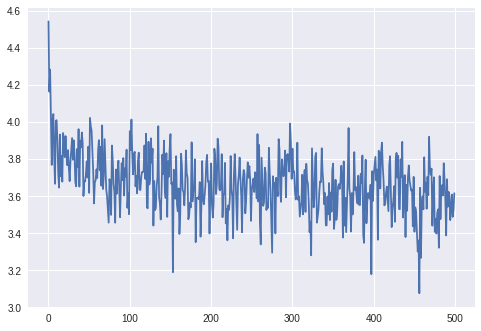

In [0]:
sig_encoder = SignatureEncoder(weights_matrix, input_lang).to(device)
decoder1 = DecoderRNN(iisignature.siglength(50, 2), output_lang.n_words).to(device)

trainIters_Sig(sig_encoder, decoder1, n_iters=50000, print_every=1000, pairs=pairs, 
               input_lang=input_lang, output_lang=output_lang)